In [ ]:
!pip install --upgrade --pre --extra-index https://pypi.anaconda.org/scipy-wheels-nightly/simple scikit-learn
!nvidia-smi
!pip install mne
!pip install tensorflow-addons
!pip install scikit-learn
!pip install tqdm
!pip install tabulate

In [ ]:
import os 
os.environ['MNE_USE_NUMBA']='false'

import tensorflow as tf
import shap
import numpy as np

tf.test.gpu_device_name()


In [ ]:
# Helper function to create a snapshot of current cell and output
from IPython.core.magic import register_cell_magic
@register_cell_magic
def run_and_save(line, cell):
    'Run and save python code block to a file'
    with open(line, 'wt') as fd:
        fd.write(cell)
    code = compile(cell, line, 'exec')
    exec(code, globals())



import os
try:
    networkname="../results/EEGNet_Site_Transformed"
    os.makedirs(networkname)
except:
    print('Exists')

# Define Training Parameters
- Training Target `site_as_label`
- Method of channel assignment across sites: one of ['order0', 'all', None]. Choose None, if data was already transformed to a common recording site using the `SSS` method of Taulu et al.

In [ ]:
%%run_and_save {networkname}/config.py
# save cell as config for reproducibility

import matplotlib
from libs import GeneratorCNN
matplotlib.interactive(False)
import gc
from libs import model_zoo
import BMTModel as approach
import numpy as np
from importlib import reload
from libs import utils
from libs.utils import Bunch
from libs import Multi_Class_Metrics as mcm
from tensorflow.keras import callbacks


network = model_zoo.EEGNetLawhern#Channel_Decision_Small_Shared_Out#ShallowConvNetMultiClass#inception_model#SpatialTemporalMultiClass#EEGNetLawhern#SpatialTemporalMultiClass#Channel_Decision_Small_Shared_Out#Channel_Decision_Small
#ConnectivityModel#EEGNetLawhern#ConnectivityModel#SpatialTemporalMultiClass#ConnectivityModel#Channel_Decision_Small#Channel_Decision_Model
#ShallowConvNetMultiClass#SpatialTemporalMultiClass#ShallowConvNetMultiClassLinear##SpatialAverageModel

# subject names
gc.collect()
use_stable=True
subjects = {'dementia':[],'control':[],'mci':[]}
utils.get_subjects_wrt_site(subjects,30,30,'dementia')
utils.get_subjects_wrt_site(subjects,100,100,'control')
utils.get_subjects_wrt_site(subjects,1,15,'mci')
subjects['dementia'].remove(27)

# corresponding channels of different recording sites
use_stable='all'
if use_stable=='order0':
    channel_matches = np.load('pareto_opt_matches.npy')
    channel_matches = utils.get_stable_channels(channel_matches,0).T#[:,44:46]
elif use_stable=='all':
    import json
    with open('A_B_bestpositional_hungarian.json') as f:
        match = json.load(f)
    match['matching0'].pop('info')
    channel_matches = np.array([list(match['matching0'].keys()),list(match['matching0'].values())]).astype(int)
elif use_stable is None:
    channel_matches = np.stack([np.arange(160),np.arange(160)])

#
# If site as label -> Let network classify whether recording originates from site A or site B
# otherwise classify HC, MCI, DEM
#
site_as_label = False
if site_as_label:
    num_classes = 2
else:
    num_classes = 3

# Metrics
sensitivity_mci_dem = mcm.MultiClassRecall(num_classes=num_classes,
                                           pos_ind=[1,2],
                                           average='macro',
                                           name="mci_dem_sensitivity")
specificity_mci_dem = mcm.MultiClassSpecificity(num_classes=num_classes,
                                                pos_ind=[1,2],
                                                average='macro',
                                                name="mci_dem_Specificity")
f1_mci_dem = mcm.MultiClassF1(num_classes=num_classes,
                              pos_ind=[1,2],average='macro',
                              name="mci_dem_F1")
metrics = ['acc', sensitivity_mci_dem, specificity_mci_dem,f1_mci_dem]


monitor = "val_loss"
if "loss" in monitor:
    mode = "min"
else:
    mode = "max"
callbacks = [callbacks.EarlyStopping(patience=8,
                                     restore_best_weights=True,
                                     monitor=monitor,
                                     mode=mode,
                                     verbose=1)]


frame_size = utils.Bunch(value=2,unit='s')
fs = 256
batch_size = 16
network_params = {
    'batch_size':batch_size,
    'use_bn':True,
    'do_ratio':0.2,
    'numTrainEpochs':20,
    'optimizer':'adam',#tf.keras.optimizers.Adam(learning_rate=0.01*np.sqrt(batch_size/32)),
    'learning_rate':0.01*np.sqrt(batch_size/32),
    'frame_size':frame_size,
    'cross_subjects':True,
    'num_classes':num_classes,
    'n_folds':5,
    'use_class_weights':True,
    'workers':16,
    'multiprocessing':False,
    'aggregation':'max',
    'site_sampling':False,
    }
    
# Params which define preprocessing is applied to data
data_params={
             'standardize':'em_astd',#'ema',#'look_at_time',
             'fs':fs,
             'channel_matches':channel_matches,
             'subjects':subjects,
             'test_ratio':0.2,
             'utility_data':r'../cache/utility_data',
             'readSubjects_params':{
                 'use_multiprocessing':False,
                 'site_as_label':site_as_label,
                 'l_freq':None,
                 'h_freq':40,
                 'frame_length':utils.time2samples(fs=fs,time_container=network_params['frame_size']),
                 'bad_samples_path':r'../cache/bad_samples',
                 'utility_data':r'../cache/utility_data'
                 },
            }
frame_length = utils.time2samples(fs=data_params['fs'],time_container=network_params['frame_size'])

# the first 80 magnetic poles describe a basis for the inner magnetic field
SA  = np.load('SA.npy')[:,:80]
SB  = np.load('SB.npy')[:,:80]
pSA = np.load('pSA.npy')[:80]
pSB = np.load('pSB.npy')[:80]

# Build augmentation pipeline for Generator
function_params = {}
function_params['draw_random_time_frame']={
   'frame_length':frame_length,
   'trial_length':5*60*data_params['fs']}
function_params['additive_correlated_noise']={'sigma_noise':5e-2}
function_params['randomize_uncorrelated_phase']={'max_delta_phase':np.pi*2/3,
                                             'fs':fs,
                                             'freq_selective':False,
                                             'frame_length':frame_length}
function_params['randomize_shared_phase'] = {'max_delta_phase':np.pi*2/3,
                                             'fs':fs,
                                             'freq_selective':False,
                                             'frame_length':frame_length}

# augmentation functions
functions=[GeneratorCNN.draw_random_time_frame,
           GeneratorCNN.additive_correlated_noise,
           GeneratorCNN.randomize_shared_phase,
           GeneratorCNN.randomize_uncorrelated_phase,
           ]

# probability of using the augmentations
prob = {
        'draw_random_time_frame':1.0,
        'additive_correlated_noise':0.5,
        'randomize_shared_phase':0.,
        'randomize_uncorrelated_phase':0.0,
        }

train_aug_pipe=GeneratorCNN.Augment_Pipeline(functions=functions,
                                  params=function_params,
                                  p=prob)
func = [
        GeneratorCNN.draw_random_time_frame,
]

p = {'draw_random_time_frame':1}
aug_params = {
    'draw_random_time_frame':
        {'frame_length':frame_length,
        'trial_length':5*60*data_params['fs']}
        }
valid_pipe = GeneratorCNN.Augment_Pipeline(func,aug_params,p)



#### Creater trainer for fit and test

In [ ]:

# Create trainer and pass location of (preprocessed) .fif files to trainer
#'../cache/sss_proj_ecg_eog', # 
# r'../cache/proj_ecg_eog',
trainer = approach.RunTraining(dataDir=[r'../cache/common_site'], # all recordings were transformed to a common recording site
                               train_path_info='./info',
                               static_data_params=data_params,
                               network_params=network_params,
                               completeDir=networkname)

In [ ]:
last_model = trainer.start_main(network=network, # pass only model architecture -> reinstantiate model for multiple folds
                                augmentations_tf=augmenter, # pass model that makes data augmentations
                                metrics=metrics,
                                callbacks_list=callbacks)

In [ ]:
#### Define Quick test for network 
from tensorflow.keras import models
def get_test_objects(fold,network,trainer,network_params,data_params):
    overlap = 128
    func = [
            GeneratorCNN.draw_continuous_time_frame,]
    p = {'draw_continuous_time_frame':1}
    aug_params = {
        'draw_continuous_time_frame':
            {'frame_length':utils.time2samples(fs=data_params['fs'],time_container=network_params['frame_size']),
            #'trial_length':5*60*data_params['fs']
             'overlap':overlap
             }
            }
    test_pipe = GeneratorCNN.Augment_Pipeline(func,aug_params,p)
    test_pipe.params['overlap']=overlap
    input_shape = (utils.time2samples(fs=data_params['fs'],time_container=network_params['frame_size']),160,1)
    model = network(input_shape,network_params=network_params)
    model = trainer.load_model(fold,model=model)
    
    feature_model = models.Model(model.input,model.layers[-3].output)
    return test_pipe, model, feature_model

In [ ]:

# Run tests on 5 folds
for fold in np.arange(0,5,1):
    model = trainer.continue_training(fold,network,metrics=metrics,
                                           callbacks_list=callbacks)
    del model
    test_pipe, last_model, feature_model = get_test_objects(fold,network,trainer,network_params,data_params)
    results = trainer.test_model(last_model,test_pipe,fold=fold,keep_data=True, 
                                 data_loaded=False,iterative=False)
    conf_mat = trainer.evaluate3classes(results[0],results[1],fold=fold,metrics=metrics[1:])
    """
    results_features_test = trainer.test_model(feature_model,test_pipe,fold,
                                                 keep_data=False,data_loaded=True,
                                                 subject_group='test_subjects.json',
                                                 iterative=False,
                                                 make_classification=False)
    results_features_train = trainer.test_model(feature_model,test_pipe,fold,
                                                 keep_data=False,data_loaded=False,
                                                 subject_group='train_subjects.json',
                                                iterative=True,
                                                make_classification=False)
    """

In [ ]:
trainer.plotSHAP(last_model,0,data=None,subject_group="test_subjects.json")

In [12]:
X = trainer.data['X']
y = trainer.data['Y']


num_channels = X.shape[-1]
assert num_channels == 160

backgrounds_per_subject = 5 # this will result in #subjects * 5 backgrounds. A high number is comput expensive.
background = []
for i, subject in enumerate(trainer.meta['subjects']):
    # ToDo: Check whether it makes sense to take background from test or train set
    # select a few time frames of the current subject
    start_times = np.random.choice(X.shape[-1],
                                   backgrounds_per_subject,
                                   replace=False)
    frame_size = utils.time2samples(fs=data_params['fs'],time_container=network_params['frame_size'])
    start_time_points_range = np.array([np.arange(sp,sp+frame_size) for sp in start_times])
    Xframes = X[[i]*backgrounds_per_subject,start_time_points_range.T]
    # select a set of background examples to take an expectation over
    background += [Xframes]
    # explain predictions of the model on four images
background = np.array(background)
# collapse subjects and frames on first axis
background = np.transpose(background,[0,2,1,3])
background = np.reshape(background,(-1,frame_size,num_channels))


last_model.predict(background[0:1,:,:,np.newaxis])

(60, 76800, 160)


In [ ]:
#[(k,s['condition'],s['id']) for k,s in enumerate(trainer.meta['subjects'])]

### Visualize SHAP explanations for model classification

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `

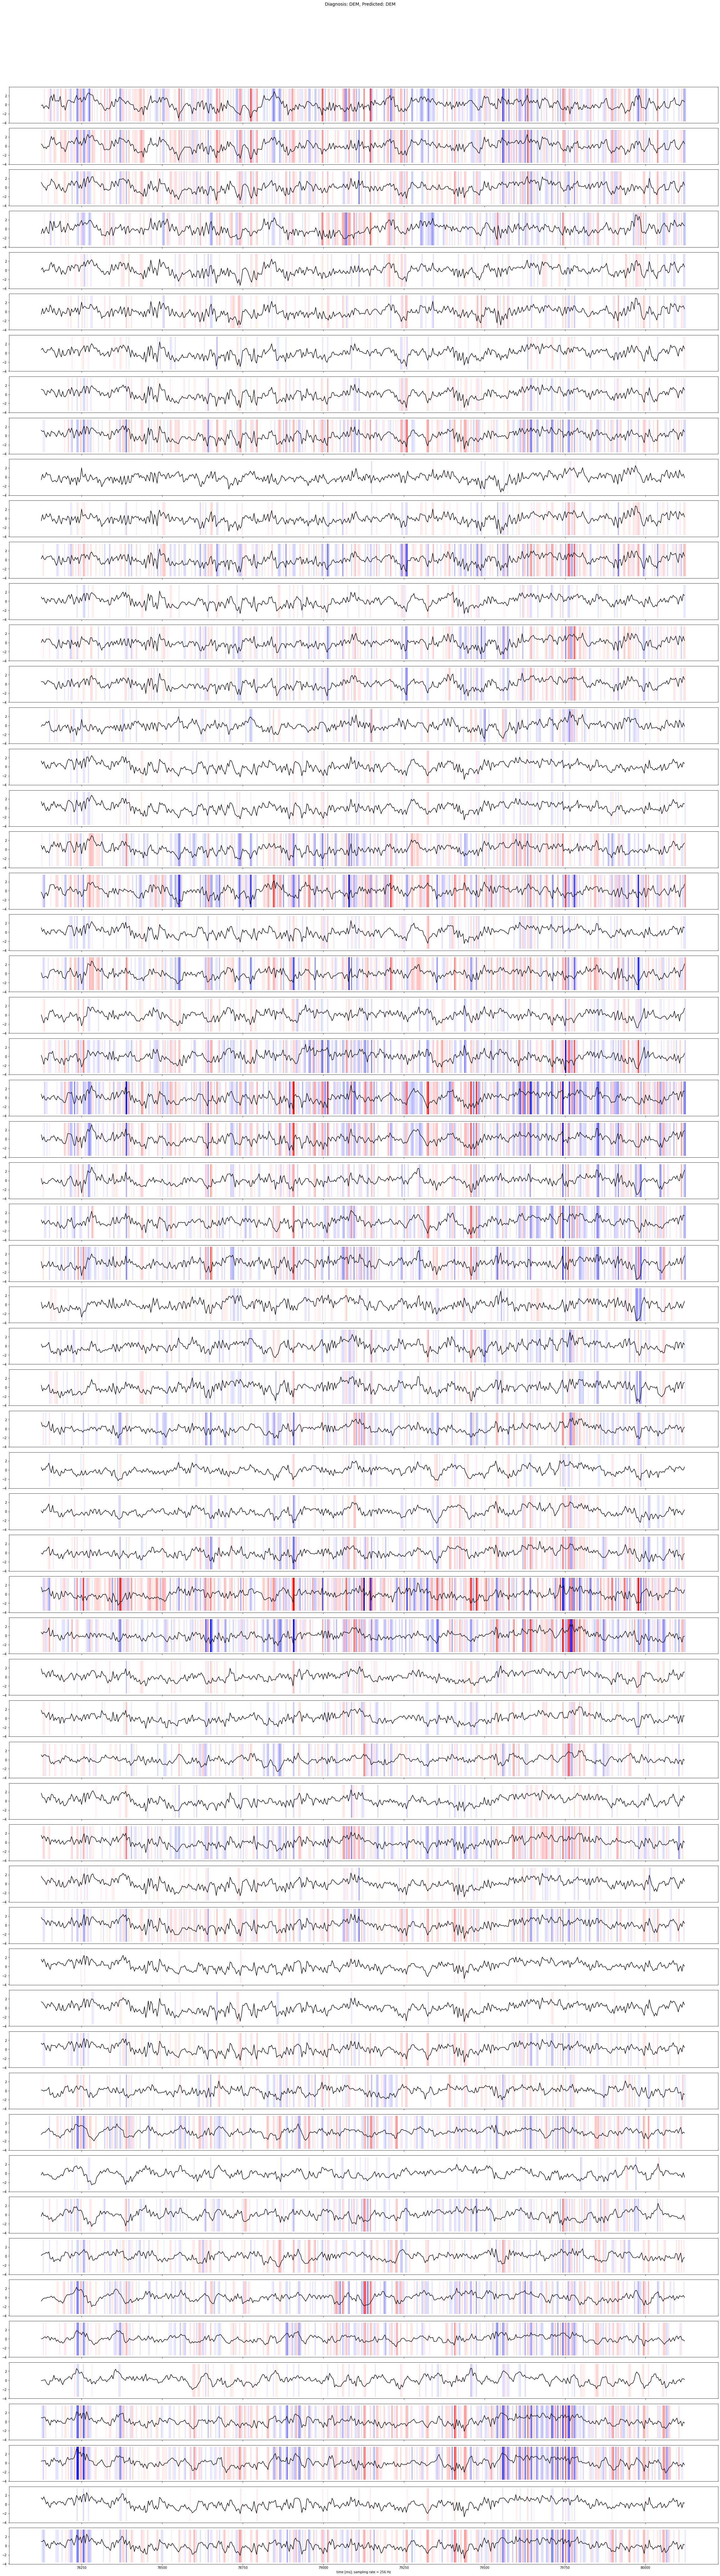

In [23]:
class_idx = 2
subject_idx = 15

import matplotlib.pyplot as plt
from matplotlib.path import Path
from matplotlib.patches import PathPatch

# same scale as in shap library

#norm = matplotlib.colors.Normalize(vmin=0, vmax=3)
t0 = 20000
label_encoding = {0:'HC',1:'MCI',2:'DEM'}
channels = np.arange(20)
time = np.arange(t0,t0+frame_size,1)/fs*1000

def plot_SHAP_time_series(X,shap_values,class_idx=0,channels=[0,],diagnosis=None,predicted=None):
    patch_start_y = X.min()
    patch_end_y = X.max()
    
    # scaling factor for colorintensity
    max_val = np.nanpercentile(np.abs(shap_values[class_idx]), 99.9)
    
    # Threshold for SHAP values which are to be displayed
    p90 = np.quantile(shap_values[0],.8,axis=(1,2,3))
    p10 = np.quantile(shap_values[0],.2,axis=(1,2,3))
    
    dt = time[1]-time[0]
    fig,ax = plt.subplots(nrows=len(channels), sharex=True,figsize=(32,2*len(channels)))
    fig.subplots_adjust(hspace=0)
    for ch in channels:
        ax[ch].plot(time,X[:,ch],color='k')
        def colorize_relevant_parts(where,color):
            patch_start_x = time[where]
            patch_end_x   = patch_start_x+dt
            # relevance is understood as the amplitude of the shap value
            relevance = np.abs(shap_values[0][0,where,ch,0])
            for i in range(sum(where)):
                path = Path([[patch_start_x[i], patch_start_y],
                             [patch_end_x[i], patch_start_y], 
                             [patch_end_x[i], patch_end_y],
                             [patch_start_x[i], patch_end_y], 
                             [patch_start_x[i], patch_start_y]])
                patch = PathPatch(path, facecolor=color+[np.clip(relevance[i]/max_val,0,1)],
                                  edgecolor='none')
                ax[ch].add_patch(patch)

        #######################################
        ##### Features for Positive Predicition
        #######################################
        colorize_relevant_parts(shap_values[class_idx][0,:,ch,0]>p90,[1,0,0])
        #######################################
        ##### Features for Negative Predicition
        #######################################
        colorize_relevant_parts(shap_values[class_idx][0,:,ch,0]<p10,[0,0,1])


    plt.setp([a.get_xticklabels() for a in fig.axes[:-1]], visible=False)    
    ax[-1].set_xlabel('time [ms]; ' + 'sampling rate = ' + str(fs) + " Hz")
    #plt.colorbar()
    
    if (diagnosis is not None) and (predicted is not None):
        fig.suptitle("Diagnosis: {}, Predicted: {}".format(diagnosis,predicted),fontsize=14)
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()
    return fig
    


test_frame = X[subject_idx:subject_idx+1,t0:t0+frame_size,:,np.newaxis]
frame_prediction = last_model.predict(test_frame)
frame_label = y[subject_idx]

num_samples = len(test_frame)    
shap.explainers._deep.deep_tf.op_handlers["FusedBatchNormV3"] = shap.explainers._deep.deep_tf.linearity_1d(0)
#edeep = shap.DeepExplainer(last_model,background[:,:,:,np.newaxis])
#svdeep = edeep.shap_values(test_frame)    
e = shap.GradientExplainer(last_model,background[:,:,:,np.newaxis],batch_size=1)
sv = e.shap_values(test_frame)
fig = plot_SHAP_time_series(test_frame[0,:,:,0],sv,class_idx=0,
                            channels=np.arange(60),
                            diagnosis=label_encoding[frame_label],
                            predicted=label_encoding[int(np.argmax(frame_prediction))])



